In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print('x_train:', x_train.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10
# Din = 784 # MINIST

# Normalize pixel values
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


x_train: (50000, 32, 32, 3)


In [5]:
batch_size = Ntr
iterations = 300
lr = 1.4e-2
lr_decay= 0.999
reg = 5e-6
loss_history = []
train_acc_history = []
val_acc_history = []

In [6]:
def calc_loss(y, y_pred, w1, w2 = 0):
    batch_size=y_pred.shape[0]
    loss = 1./batch_size*np.square(y_pred - y).sum() + reg*(np.sum(w2*w2) + np.sum(w1*w1))
    return loss

In [7]:
def accuracy(y_pred,y):
    batch_size=y_pred.shape[0]
    K=y_pred.shape[1]
    acc=1-(1/(batch_size*K))*(np.abs(np.argmax(y,axis=1)-np.argmax(y_pred,axis=1))).sum()
    return acc

In [21]:
H = 200

def twoLayerModel(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg):
    Ntr = x_train.shape[0]
    Nte = x_test.shape[0]

    loss_history = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    std=1e-6
    w1 = std*np.random.randn(Din, H)
    w2 = std*np.random.randn(H, K)
    b1 = np.zeros(H)
    b2 = np.zeros(K)

    for t in range(iterations):
        indices = np.arange(Ntr)
        rng.shuffle(indices)
        x=x_train[indices]
        y=y_train[indices]
        
        #forward propagation
        h = 1.0/(1.0 + np.exp(-(x.dot(w1) + b1)))
        h1 = 1.0/(1.0 + np.exp(-(x_test.dot(w1) + b1)))
        y_pred = h.dot(w2) + b2
        y_pred_test = h1.dot(w2) + b2
        train_loss=calc_loss(y_pred,y,w1,w2)
        test_loss=calc_loss(y_pred_test,y_test,w1,w2)
        loss_history.append(train_loss)

    
        train_acc=accuracy(y_pred,y)
        train_acc_history.append(train_acc)
        test_acc=accuracy(y_pred_test,y_test)
        val_acc_history.append(test_acc)
        
        if t%10 == 0:
            print('epoch %d/%d: train loss= %f ,test loss= %f,train accracy= %f, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,test_acc))

        #backward propagation
        dy_pred=(1./batch_size)*2.0*(y_pred-y)
        dw2 = h.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis=0)
        dh = dy_pred.dot(w2.T)
        dw1 = x.T.dot(dh*h*(1-h))+reg*w1
        db1 = (dh*h*(1-h)).sum(axis=0) 
        w1-=lr*dw1
        w2-=lr*dw2
        b1-=lr*db1
        b2-=lr*db2
        lr*=lr_decay
        
    return w1,b1,loss_history,train_acc_history,val_acc_history

In [22]:
w1,b1,loss_history,train_acc_history,val_acc_history=twoLayerModel(x_train,y_train,x_test,y_test,K,Din,lr,lr_decay,reg)

epoch 0/300: train loss= 1.000004 ,test loss= 1.000004,train accracy= 0.690000, test accracy= 0.690000
epoch 10/300: train loss= 0.884744 ,test loss= 0.885070,train accracy= 0.673166, test accracy= 0.674620
epoch 20/300: train loss= 0.846621 ,test loss= 0.846256,train accracy= 0.720072, test accracy= 0.720760
epoch 30/300: train loss= 0.831829 ,test loss= 0.831454,train accracy= 0.732478, test accracy= 0.734580
epoch 40/300: train loss= 0.820838 ,test loss= 0.821298,train accracy= 0.742686, test accracy= 0.742870
epoch 50/300: train loss= 0.818239 ,test loss= 0.818886,train accracy= 0.749864, test accracy= 0.752490
epoch 60/300: train loss= 0.801904 ,test loss= 0.803489,train accracy= 0.766550, test accracy= 0.765130
epoch 70/300: train loss= 0.797328 ,test loss= 0.799510,train accracy= 0.762988, test accracy= 0.763890
epoch 80/300: train loss= 0.792666 ,test loss= 0.794767,train accracy= 0.769980, test accracy= 0.770720
epoch 90/300: train loss= 0.785881 ,test loss= 0.789084,train acc

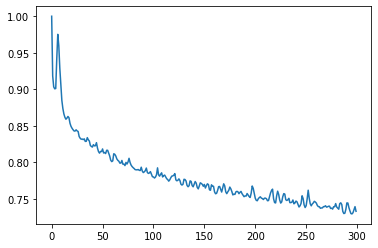

In [23]:
x_axis=np.arange(len(loss_history))
plt.plot(x_axis,loss_history)

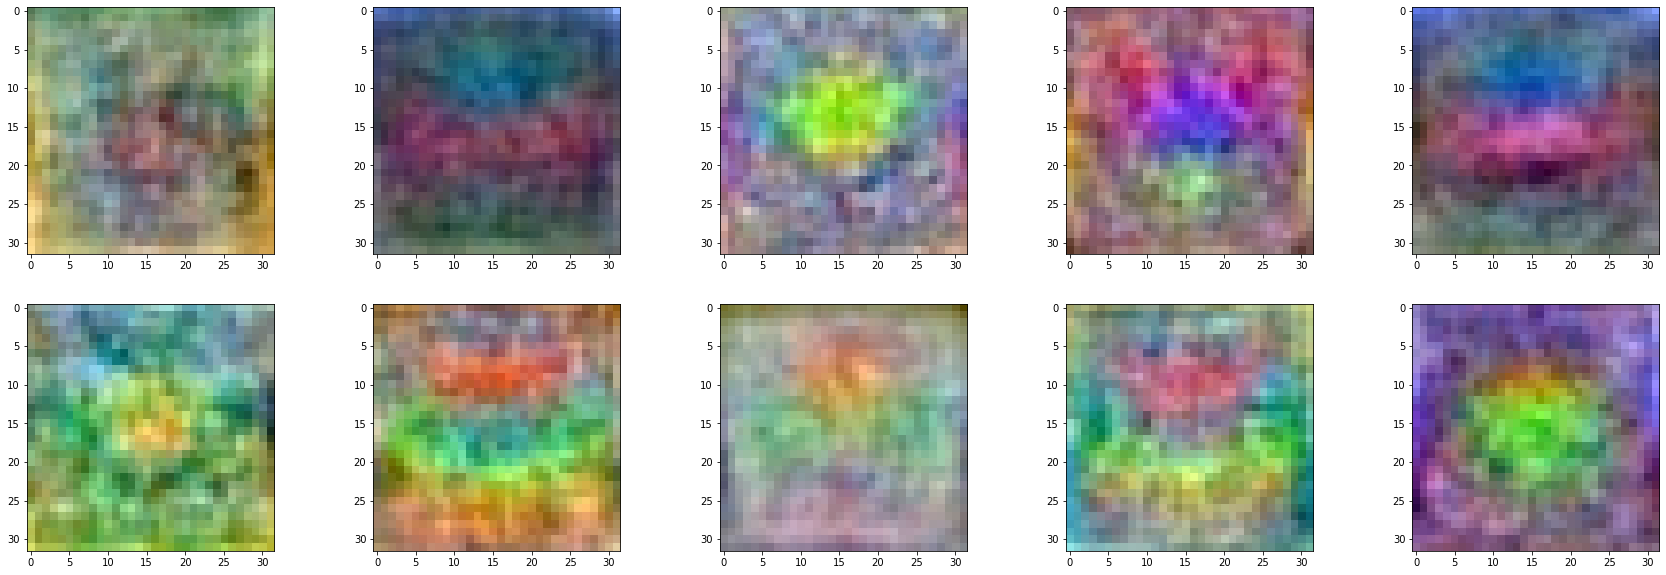

In [24]:
images=[]
for i in range(w1.shape[1]):
    #images.append(np.reshape(w1[:,i]*255,(32,32,3))+np.reshape(mean_image,(32,32,3)))
    temp=np.reshape(w1[:,i]*255,(32,32,3))
    temp=cv.normalize(temp, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    images.append(temp)
fig,ax=plt.subplots(2,5,figsize=(30,10))
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(images[i*5+j],vmin=0,vmax=255)
plt.show()
